In [5]:
# Required imports
import pickle

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as ms

from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier


from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')

#GLOBALS
MAX_WORDS = 20000

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Utility functions
# PRE PROCESSING FUNCTIONS
nltk_wordnet_tag_map = {
    'NN': wn.NOUN,
    'NNS': wn.NOUN,
    'VBP': wn.VERB,
    'VBG': wn.VERB,
    'JJ': wn.ADJ,
}

from functools import reduce
import string
import re

def compose(*functions):
    def compose2(f1, f2):
        """Compose two functions"""
        return lambda *args: f1(f2(*args))
    return reduce(compose2, functions)

def translate_to_english_txt(row):
    text = row["excerpt"]
    try:
        if langid.classify(text)[0] != 'en':
            trans = googletrans.client.Translator()
            return trans.translate(text, 'en').text
        return text
    except Exception as e:
        return ''
    
def lemmatize(row, lemmatizer=WordNetLemmatizer()):
    text = row
    splitted = text if type(text) == list else str(text).split()
    splitted = list(map(lambda x: str(x).lower(), splitted))
    tagged = nltk.pos_tag(splitted)
    lemmatized = []
    for word, tag in tagged:
        wnet_tag = nltk_wordnet_tag_map.get(tag)
        if wnet_tag:
            lemmatized.append(lemmatizer.lemmatize(word, wnet_tag))
        else:
            lemmatized.append(word)
    return ' '.join(lemmatized)

def rm_punc_not_nums(inp, col=None):
    """Remove punctuation unless it's a number for either a df (and col)
    or single entry
    """
    punc = string.punctuation
    transtable = str.maketrans("", "", punc)

    def sing_rm(phr):
        """Remove for a single entity"""
        return ' '.join([re.sub('\W+', '', i).translate(transtable) if not (
                    all(j.isdigit() or j in punc for j in i)
                    and
                    any(j.isdigit() for j in i)
                ) else re.sub('\W+', '', i)
                for i in str(phr).split(' ')]
        )
    if col and isinstance(inp, pd.core.frame.DataFrame):
        return inp.filter(like=col).applymap(lambda phr: sing_rm(phr))
    elif isinstance(inp, str):
        return sing_rm(inp)
    else:
        raise Exception('Not a vaild type')


def rm_stop_words_txt(txt, swords=nltk.corpus.stopwords.words('english')):
    """ Remove stop words from given text """
    return ' '.join(
        [token for token in str(txt).split(' ')
            if token.lower() not in swords]
    )

def preprocess(row):
    inp = row["excerpt"]
    inp = lemmatize(inp)
    func = compose(
        rm_punc_not_nums,
        rm_stop_words_txt,
        ' '.join,
        str.split,
        str.lower,
        str
    )

    return func(inp)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def model_cross_validate(features, labels, model):
    print ("Cross Validating: {0}".format(model["name"]))
    print ("features shape", features.shape)
    print ("Labels shape", labels.shape)
    scoring = ['accuracy', 'precision_macro', 'recall_macro']
    scores = cross_validate(model["model"], features, labels, scoring=scoring, cv=ms.KFold(n_splits=10, shuffle = True, random_state=7), return_train_score=False)
    k = list(range(10))
    plt.scatter(k, scores['test_accuracy'])
    plt.scatter(k, scores['test_precision_macro'])
    plt.scatter(k, scores['test_recall_macro'])
    plt.ylabel("Percentage")
    plt.xlabel("Iteration")
    plt.title("{0} 10 Folds Cross Validation".format(model["name"]))
    plt.legend(['Testing Accuracy', 'Testing Precision', 'Testing Recall'], loc='upper left')

In [3]:
# Create data frame
# data_path = "../_playground/sample_data/processed_sectors_subsectors.csv"
data_path = "../_playground/sample_data/preprocessed_data.csv"
def create_preprocessed_data_frame(data_path="../_playground/sample_data/preprocessed_data.csv"):
    df = pd.read_csv(data_path)
    df.drop_duplicates(["preprocessed_excerpt"], inplace=True)
    #df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1, inplace=True)
    #df["preprocessed_excerpt"] = df.apply(preprocess, axis=1)
    return df

# df = create_preprocessed_data_frame()
df = pd.read_csv(data_path)

In [43]:
# Getting dictionary and tfidfs

def get_documents_and_labels(df):
    documents = []
    for x in df['preprocessed_excerpt']:
        documents.append(str(x).strip())
    labels = np.array(list(df['sector'].values))
    print ('%d data items' % len(documents))
    return documents, labels

def get_dictionary_from_documents(documents, words_limit=MAX_WORDS):
    dictionary = Dictionary([doc.split() for doc in documents])
    if words_limit is not None:
        dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=words_limit)
    else:
        dictionary.filter_extremes(no_below=1, no_above=0.5)#, keep_n=MAX_NB_WORDS)
    dictionary.compactify()
    print('Total %s unique tokens.' % len(dictionary))
    return dictionary

def write_dictionary(dictionary, filepath="../_playground/sample_data/dictionary.pkl"):
    with open(filepath, 'wb') as fw:
        pickle.dump(dictionary, fw)
        print("Done!!")
        
def load_dictionary(filepath="../_playground/sample_data/dictionary.pkl"):
    with open(filepath, 'rb') as fw:
        return pickle.load(fw)

documents, labels = get_documents_and_labels(df)
dictionary = get_dictionary_from_documents(documents)
write_dictionary(dictionary)
#dictionary = load_dictionary()

In [6]:
# Create TFIDFs
def create_tfidf(dictionary):
    corpus = [dictionary.doc2bow(line) for line in [x.split() for x in documents]]  # convert corpus to BoW format

    weight_model = TfidfModel(corpus)  # fit model

    vectors_tfidf=[]
    for x in corpus:
        vectors_tfidf.append(weight_model[x])
    return vectors_tfidf
        
def save_tfidf_labels(tfidf, labels, vectors_tfidf_path="../_playground/sample_data/tfidf.pkl"):
    with open(vectors_tfidf_path, 'wb') as fw:
        pickle.dump([tfidf, labels], fw)
        print("DONE!!")
        
def load_vectors(path="../_playground/sample_data/tfidf.pkl"):
    with open(path, 'rb') as fw:
        vectors, labels = pickle.load(fw)
        return vectors, labels
    
#tfidf = create_tfidf(dictionary)
#save_tfidf_labels(tfidf, labels)
#vectors, labels = load_vectors()

In [17]:
# Dimension reduction

def sparsify(vectors_tfidf, dictionary):
    # first sparsifying the TFIDF vectors
    vectors_tfidf_sparse=np.zeros((len(vectors_tfidf), len(dictionary)))
    for doc_i, doc in enumerate(vectors_tfidf):
        for item in doc:
            vectors_tfidf_sparse[doc_i][item[0]] = item[1]
    return vectors_tfidf_sparse

def reduce_dimensions_and_write_to_file(sparse_vector, labels, dimensions):
    pca = PCA(n_components=dimensions)
    vectors_tfidf_dim = pca.fit_transform(sparse_vector)
    filepath = "tfidf_dim{}.pkl".format(dimensions) 
    with open(filepath, "wb") as fw:
        pickle.dump([vectors_tfidf_dim, labels], fw)
        print("Written to file {}".format(filepath))
    return vectors_tfidf_dim

#print(len(dictionary), len(tfidf))
#sparse_vecs = sparsify(tfidf, dictionary)
#tfidf_dim100 = reduce_dimensions_and_write_to_file(sparse_vecs, labels, 100)
#tfidf_dim300 = reduce_dimensions_and_write_to_file(sparse_vecs, labels, 300)
#tfidf_dim500 = reduce_dimensions_and_write_to_file(sparse_vecs, labels, 500)

In [43]:
# LOADING DATA

TEST_SPLIT = 0.2
DATA_PATH = "../_playground/sample_data"

dims = [
    #'unreduced',
    #'dim100',
    'dim300',
    'dim500'
]


DATA = {
}

for dim in dims:
    if dim == 'unreduced':
        path = "{}/tfidf.pkl".format(DATA_PATH)
    else:
        path = "{}/tfidf_{}.pkl".format(DATA_PATH, dim)
        
    vectors, labels = load_vectors(path)
    if isinstance(vectors[0][0], tuple) :
        vectors_sparse = np.zeros((len(vectors), MAX_WORDS))
        for doc_i, doc in enumerate(vectors):
            for item in doc:
                vectors_sparse[doc_i][item[0]] = item[1]
        vectors = vectors_sparse
    # x_tr, x_ts, y_tr, y_ts = train_test_split(vectors, labels, test_size=TEST_SPLIT, random_state=42)
    
    DATA[dim] = {
        'X': vectors[:100],
        'Y': labels[:100]
    }
# # Unreduced vectors
# x_train, x_test, y_train, y_test = train_test_split(vectors, labels, test_size=TEST_SPLIT, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

# # dim 100 vectors
# vectors100, labels = load_tfidf("{}/tfidf_dim100.pkl")
# x_train100, x_test100, y_train100, y_test100 = train_test_split(vectors, labels, test_size=TEST_SPLIT, random_state=42)
# x_train100, x_val100, y_train100, y_val100 = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

# # dim 300 vectors
# vectors300, labels = load_tfidf("{}/tfidf_dim300.pkl")
# x_train300, x_test300, y_train300, y_test300 = train_test_split(vectors, labels, test_size=TEST_SPLIT, random_state=42)
# x_train300, x_val300, y_train300, y_val300 = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

# # dim 500 vectors
# vectors500, labels = load_tfidf("{}/tfidf_dim500.pkl")
# x_train500, x_test500, y_train500, y_test500 = train_test_split(vectors, labels, test_size=TEST_SPLIT, random_state=42)
# x_train500, x_val500, y_train500, y_val500 = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

In [48]:
# MODELS
models = {
    #'dummy': DummyClassifier(strategy='stratified'),
    'logistic_regression': LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500),
    'naive_bayes': GaussianNB(),
    #'svc': SVC(kernel='sigmoid', gamma='auto'),
    'decision_tree': DecisionTreeClassifier(),
    #'random_forest_est_100': RandomForestClassifier(n_estimators=100, random_state=1),
#     'ensemble': VotingClassifier(estimators=[
#             ('nb', GaussianNB()),
#             ('lr', LogisticRegression(solver='liblinear', multi_class='auto')),
#             ('svc', SVC(kernel='sigmoid', gamma='auto')),
#             ('forest', RandomForestClassifier(n_estimators=100, random_state=1))
#         ], voting='hard')
}

def snake_to_titled(string):
    return ' '.join([x.title() for x in string.split('_')])

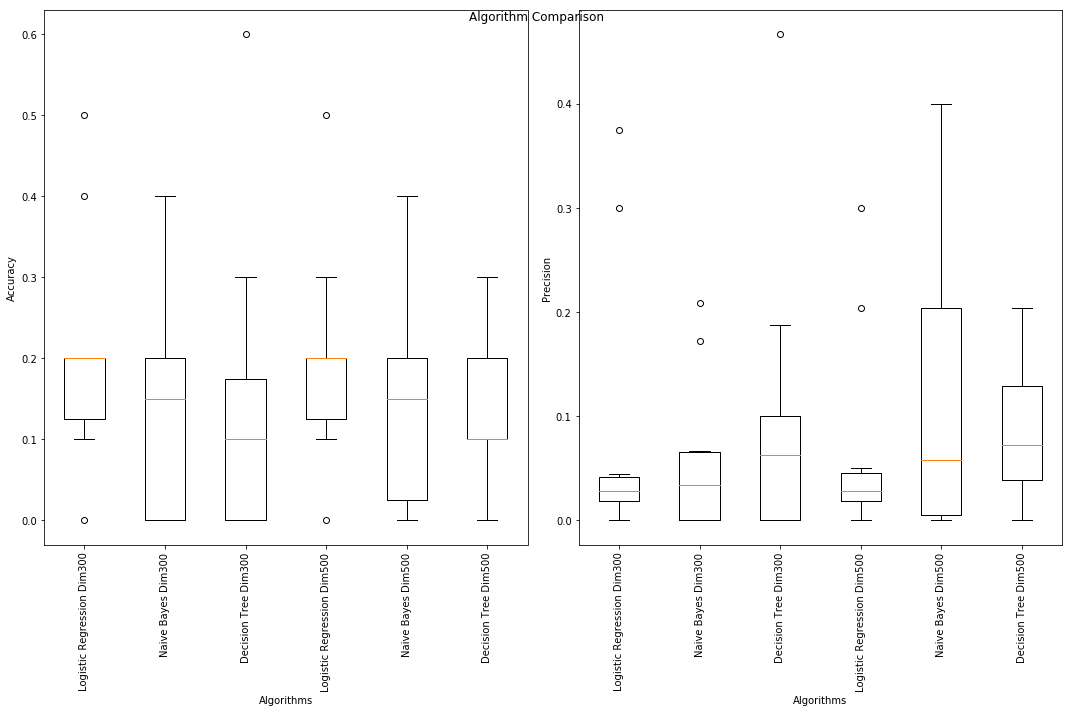

In [51]:
import warnings
import datetime
warnings.filterwarnings("ignore")

def compare_accuracies(models, vectors_data):
    names = []
    acc_results = []
    precision_results = []
    seed = 7
    scoring = ('accuracy', 'precision_macro')
    #scoring = 'accuracy'
    for dim, data in vectors_data.items():
        X = np.asarray(data['X'])
        Y = np.asarray(data['Y'])
        for name, model in models.items():
            names.append(snake_to_titled(name + ('_'+dim if dim != 'unreduced' else '')))
            kfold = ms.KFold(n_splits=10, random_state=seed)
            cv_results = ms.cross_validate(model, X, Y, cv=kfold, scoring=scoring)
            acc_results.append(cv_results['test_accuracy'])
            precision_results.append(cv_results['test_precision_macro'])
            
    fig = plt.figure(figsize=(15,10))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(121)
    plt.boxplot(acc_results)
    ax.set_xticklabels(names)
    ax.set_xlabel("Algorithms")
    ax.set_ylabel("Accuracy")
    plt.xticks(rotation=90)

    ax = fig.add_subplot(122)
    plt.boxplot(precision_results)
    ax.set_xticklabels(names)
    ax.set_xlabel("Algorithms")
    ax.set_ylabel("Precision")
    
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.savefig("benchmarks-{}.png".format(datetime.datetime.now().date().isoformat()))
    plt.show()

compare_accuracies(models, DATA)

In [ ]:
EVAL_AVGTYPE = 'macro avg'
EVAL_MEASURE = 'precision'
colors = ['r','g','b','c', 'm','y']

def plot_measures(results, avg_type=EVAL_AVGTYPE, measures=[EVAL_MEASURE]):
    fig = plt.figure(figsize=(8,6)) 
    labels = modelnames
    x = np.asarray([i for i in range(len(labels))])

    #plt.bar(labels, data)
    ax = plt.subplot(111)
    for i, measure in enumerate(measures):
        y = [results[l][avg_type][measure] for l in labels]
        ax.bar(x+i*0.2, y,width=0.2,color=colors[i],align='center', label=measure)
    
    ax.set_xticks(x)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticklabels(labels)   
    plt.legend()
    
    plt.ylabel("", fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    #ax.yaxis.grid(True)
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

    
plot_measures(results, measures=['precision', 'recall', 'f1-score'])

/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/decomposition/sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/decomposition/sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/decomposition/sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/decomposition/sparse_pca.

RF-Estimators300: 0.155556 (0.139222)
RF-Estimators100: 0.155556 (0.139222)
RF-Estimators50: 0.176667 (0.151897)
LogisticRegression: 0.175556 (0.101446)
KNearestNeighbors: 0.010000 (0.030000)
NB-TF: 0.102222 (0.154983)
NB-TFIDF: 0.070000 (0.141774)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA100: 0.091111 (0.104563)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA50: 0.083333 (0.078920)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA200: 0.052222 (0.052364)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA300: 0.031111 (0.047610)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA400: 0.092222 (0.094679)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA500: 0.051111 (0.051208)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA600: 0.061111 (0.067082)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA700: 0.072222 (0.081989)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA800: 0.092222 (0.106927)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA900: 0.070000 (0.078102)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RF-PCA1000: 0.041111 (0.050442)


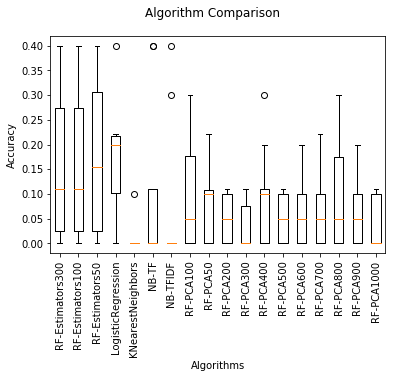

In [31]:
def compare_models(models_X_Y):
    """
    @models_X_Y: [(modelname, model, X, Y), ...]
    """
    scoring = 'accuracy'
    seed = 7
    results = []
    names = [x[0] for x in models_X_Y]
    for name, model, X, Y in models_X_Y:
        kfold = ms.KFold(n_splits=10, random_state=seed)
        cv_results = ms.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    ax.set_xlabel("Algorithms")
    ax.set_ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.show()

models_X_Y = []

df = create_data_frame()

models_X_Y.append(
    get_features_labels_for_random_forest(df.copy(), name="RF-Estimators300", n_estimators=300)
)
# random forest with less estimators
models_X_Y.append(
    get_features_labels_for_random_forest(df.copy(), name="RF-Estimators100", n_estimators=100)
)
models_X_Y.append(
    get_features_labels_for_random_forest(df.copy(), name="RF-Estimators50", n_estimators=50)
)
models_X_Y.append(
    get_features_labels_for_logistic_regression(df.copy())
)
models_X_Y.append(
    get_features_labels_for_KNN(df.copy())
)

models_X_Y.append( ## NAIVE BAYES WITH TF only (no IDF)
    get_features_labels_for_naive_bayes(df.copy())
)

models_X_Y.append( ## NAIVE BAYES WITH TFIDF
    get_features_labels_for_naive_bayes_tfidf(df.copy())
)

models_X_Y.append( ## Random Forest WITH dimension reduced TFIDF
    get_features_labels_for_random_forest_PCA(df.copy())
)
models_X_Y.append( ## Random Forest WITH dimension reduced TFIDF
    get_features_labels_for_random_forest_PCA(df.copy(), n_components=50)
)
# increase dimensions for Random forest
for x in range(200, 1001, 100):
    models_X_Y.append( ## Random Forest WITH dimension reduced TFIDF
        get_features_labels_for_random_forest_PCA(df.copy(), n_components=x)
    ) 
compare_models(models_X_Y)


training time RF-Estimators300: 0.9880235195159912
testing time RF-Estimators300: 0.07253241539001465
training time RF-Estimators100: 0.3484189510345459
testing time RF-Estimators100: 0.028863191604614258
training time RF-Estimators50: 0.16109871864318848
testing time RF-Estimators50: 0.01695990562438965
training time LogisticRegression: 0.01774120330810547
testing time LogisticRegression: 0.0008356571197509766
training time KNearestNeighbors: 0.0020194053649902344
testing time KNearestNeighbors: 0.0056536197662353516
training time NB-TF: 0.006417274475097656
testing time NB-TF: 0.0014340877532958984
training time NB-TFIDF: 0.006360054016113281
testing time NB-TFIDF: 0.0013871192932128906
training time RF-PCA100: 0.023601055145263672
testing time RF-PCA100: 0.0040283203125
training time RF-PCA50: 0.022543907165527344
testing time RF-PCA50: 0.002957582473754883
training time RF-PCA200: 0.023859024047851562
testing time RF-PCA200: 0.002979278564453125
training time RF-PCA300: 0.024577617

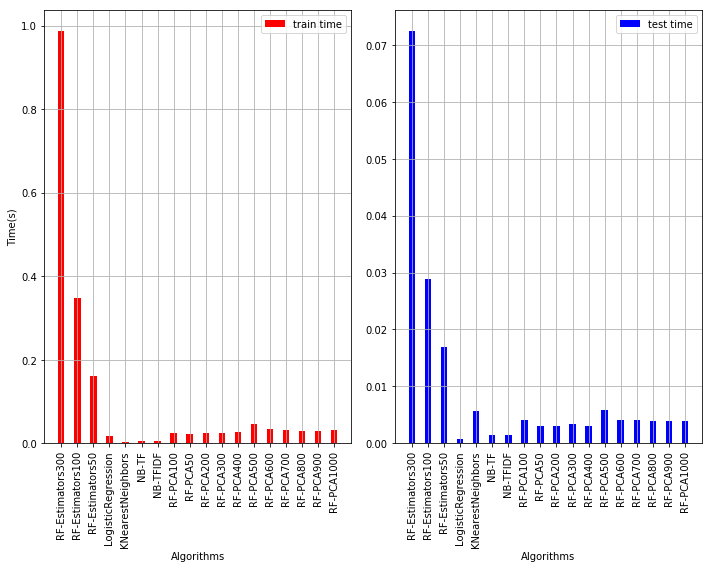

In [40]:
## Benchmark the speeds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import time
import datetime

def benchmark_speed(models):
    names = []
    test_times = []
    train_times = []
    for name, model, X, Y in models:
        names.append(name)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
        ## training_time
        t0 = time.time()
        model.fit(X_train, y_train)
        t1 = time.time()
        print("training time {}: {}".format(name, t1-t0))
        train_times.append(t1-t0)
        
        ## test time
        t0 = time.time()
        predicted = model.predict(X_test)
        t1 = time.time()
        print("testing time {}: {}".format(name, t1-t0))
        test_times.append(t1-t0)

    test_times = np.array(test_times)
    train_times = np.array(train_times)
    plt.figure(figsize=(10,8))
    ax = plt.subplot(121)
    barwidth = 30
    xax = np.arange(len(names))*2.5*barwidth
    
    ax.bar(xax, train_times, width=barwidth, color='r', label='train time')
    
    # Set ticks and labels
    ax.set_xticks(xax)
    ax.set_xticklabels(names)
    ax.set_xlabel("Algorithms")
    ax.set_ylabel("Time(s)")
    # Set legends
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    plt.xticks(rotation=90)
    plt.grid()
    # for test time
    ax = plt.subplot(122)
    ax.set_xticks(xax)
    ax.set_xticklabels(names)
    ax.set_xlabel("Algorithms")
    #ax.set_ylabel("Test Time(ms)")
    ax.bar(xax, test_times, width=barwidth, color='b', label='test time')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    plt.xticks(rotation=90)
    plt.grid()
    plt.tight_layout()
    plt.savefig("benchmarks-{}.png".format(datetime.datetime.now().isoformat()))
    plt.show()

benchmark_speed(models_X_Y)